# Maritime zone labelling
for demonstartion purposes

The following script shows how the list of coordinates (EPSG:4326) could be distributed into maritime zones

The pipeline of the script:

1.   upload reference shapefiles of all maritime zones (Flanders Marine Institute (2023): MarineRegions.org. Available online at www.marineregions.org. Consulted on 2023-03-05 (CC BY 4.0))
2.   upload a table with ur samples where at least longitute and latitude should be stated
3.   for each sample get a fit into one of maritime zones (otherwise the exception is raised)
4.   show nice plots of distribution
5.   save a new table with the maritime zone column



In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.


In [3]:
import os
import numba

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd

## part 1: upload reference shapefiles

Here, we unzip a zip (maritime_zones_reference_shapefiles) with all zips (each per 12NM, 24NM, EEZ, High Seas, and Archipelagic Waters). No reference data is provided for that part due to the copyright claims.

In [5]:
# unzip a zip with zips of maritime zones shapefiles
! unzip maritime_zones_ref_shapefiles.zip

Archive:  maritime_zones_ref_shapefiles.zip
   creating: maritime_zones_ref_shapefiles/
  inflating: __MACOSX/._maritime_zones_ref_shapefiles  
  inflating: maritime_zones_ref_shapefiles/World_Archipelagic_Waters_v3_20191118.zip  
  inflating: __MACOSX/maritime_zones_ref_shapefiles/._World_Archipelagic_Waters_v3_20191118.zip  
  inflating: maritime_zones_ref_shapefiles/.DS_Store  
  inflating: __MACOSX/maritime_zones_ref_shapefiles/._.DS_Store  
  inflating: maritime_zones_ref_shapefiles/World_High_Seas_v1_20200826.zip  
  inflating: __MACOSX/maritime_zones_ref_shapefiles/._World_High_Seas_v1_20200826.zip  
  inflating: maritime_zones_ref_shapefiles/World_Internal_Waters_v3_20191118.zip  
  inflating: __MACOSX/maritime_zones_ref_shapefiles/._World_Internal_Waters_v3_20191118.zip  
  inflating: maritime_zones_ref_shapefiles/World_24NM_v3_20191118.zip  
  inflating: __MACOSX/maritime_zones_ref_shapefiles/._World_24NM_v3_20191118.zip  
  inflating: maritime_zones_ref_shapefiles/World_EEZ_

In [8]:
folder_path = './maritime_zones_ref_shapefiles'

# Get a list of all files in the folder
print('In this folder are:\n', *os.listdir(folder_path), sep='\n')

In this folder are:

World_24NM_v3_20191118.zip
World_Internal_Waters_v3_20191118.zip
World_12NM_v3_20191118.zip
World_EEZ_v11_20191118.zip
World_High_Seas_v1_20200826.zip
World_Archipelagic_Waters_v3_20191118.zip


In [9]:
# unzip each zip per a maritime zone
os.system(f'for file in {folder_path}/*.zip;' + 'do unzip "$file" -d "${file%.*}"; done')

0

In [10]:
df_mar_zones = gpd.GeoDataFrame()
file_list = os.listdir(folder_path)

for file_name in file_list:
  if not file_name.endswith('.zip'):

    if file_name in os.listdir(f'{folder_path}/{file_name}/'):
        path_folder_zone = f'{folder_path}/{file_name}/{file_name}/'
    else:
        path_folder_zone = f'{folder_path}/{file_name}/'

    file_shp = list(filter(lambda x: x.endswith('.shp') and 'boundaries' not in x, os.listdir(path_folder_zone)))
    print(file_name, file_shp)
    df_zone = gpd.read_file(path_folder_zone + file_shp[0])

    if file_shp[0].startswith('High_Seas'):
      out_list = [i for i in list(list(df_zone['geometry'])[0].geoms)]
      df_zone = pd.concat([df_zone] * len(out_list), ignore_index=True)
      df_zone.geometry = out_list
      df_zone.area_km2 = df_zone.to_crs(epsg=3857).area / 1e6
      df_zone = df_zone.rename(columns={'name': 'POL_TYPE'})

    df_mar_zones = pd.concat([df_mar_zones, df_zone])

print()
df_mar_zones.head()

World_Internal_Waters_v3_20191118 ['eez_internal_waters_v3.shp']
World_Archipelagic_Waters_v3_20191118 ['eez_archipelagic_waters_v3.shp']
World_EEZ_v11_20191118 ['eez_v11.shp']
World_High_Seas_v1_20200826 ['High_Seas_v1.shp']
World_24NM_v3_20191118 ['eez_24nm_v3.shp']
World_12NM_v3_20191118 ['eez_12nm_v3.shp']



,MRGID,GEONAME,POL_TYPE,MRGID_TER1,TERRITORY1,MRGID_SOV1,SOVEREIGN1,ISO_TER1,X_1,Y_1,...,ISO_SOV2,ISO_SOV3,UN_SOV2,UN_SOV3,UN_TER2,UN_TER3,gid,mrgid,source,area_km2
0,49469.0,German Internal Waters,Internal waters,2101.0,Germany,2101.0,Germany,DEU,9.74594,54.13993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49470.0,Albanian Internal Waters,Internal waters,2153.0,Albania,2153.0,Albania,ALB,19.40797,40.87599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49471.0,Bulgarian Internal Waters,Internal waters,2174.0,Bulgaria,2174.0,Bulgaria,BGR,27.78424,42.65344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49472.0,Croatian Internal Waters,Internal waters,2160.0,Croatia,2160.0,Croatia,HRV,15.55943,43.98195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49473.0,Danish Internal Waters,Internal waters,2157.0,Denmark,2157.0,Denmark,DNK,10.66311,55.69238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# check what we have in the polygon type column
df_mar_zones.POL_TYPE.unique()

array(['Internal waters', 'Archipelagic waters', '200NM',
       'Overlapping claim', 'Joint regime', '200 NM', 'High Seas', '24NM',
       '12NM'], dtype=object)

In [12]:
# let's fix repeats
df_mar_zones.POL_TYPE = df_mar_zones.POL_TYPE.apply(lambda x: '200NM' if x=='200 NM' else x)

Text(0.5, 1.0, 'The map of available maritime zonations')

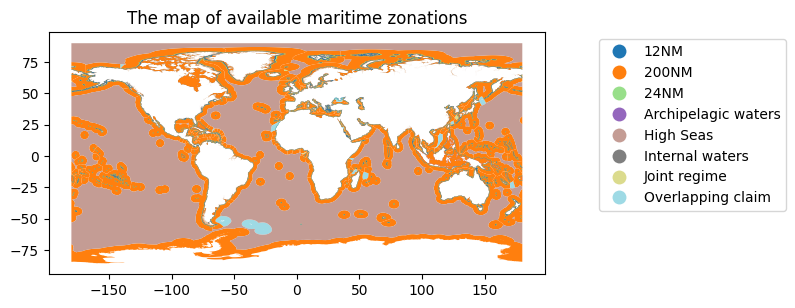

In [31]:
df_mar_zones.plot(column='POL_TYPE', cmap='tab20', 
                  legend=True).get_legend().set_bbox_to_anchor((1.5, 1))
plt.title('The map of available maritime zonations')

## part 2: upload a table with ur samples

In [14]:
# provide a link to your data
# in our case, it is Supplementary Table 1 from the Tara Ocean project (doi: 10.1038/s41564-018-0176-9)
url = 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41564-018-0176-9/MediaObjects/41564_2018_176_MOESM3_ESM.xlsx'
df_data = pd.read_excel(url, header=2).dropna(axis=1, how='all')

# Create a list of points as (longitude, latitude) tuples
points_list = df_data.loc[:, ['Longitude', 'Latitude']].to_numpy()

df_data.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Metagenomes,Number_of_sequencing_pairs,Number_of_QC_sequencing_pairs,NCBI Biosample,Location,Project,Depth_(m),Depth_Id,Size_fractionnation_(um),Year,...,Longitude,Chlorophyll Sensor s,Mean_Temperature,Mean_Salinity,Mean_Oxygen,Mean_Nitrates,NO2,PO4,NO2NO3,SI
0,ANE_004_05M,202168446,184535177,SAMEA2619376,Atlantic_Ocean_(North_East),TARA_Oceans,10.000000,SRF,0.22-1.6,2009,...,-6.566833,0.078000,20.5,36.6,NaN,NaN,NaN,NaN,NaN,NaN
1,ANE_004_40M,238146548,211851937,SAMEA2619399,Atlantic_Ocean_(North_East),TARA_Oceans,38.689029,DCM,0.22-1.6,2009,...,-6.538667,0.090621,16.2,36.6,NaN,NaN,NaN,NaN,NaN,NaN
2,ANE_150_05M,193884779,174174635,SAMEA2623808,Atlantic_Ocean_(North_East),TARA_Oceans,5.530167,SRF,0.22-3,2012,...,-37.260950,0.048898,17.6,36.3,228.4,-0.3,0.04,0.01,0.17,0.84
3,ANE_150_40M,182027367,166816431,SAMEA2623826,Atlantic_Ocean_(North_East),TARA_Oceans,39.779235,DCM,0.22-3,2012,...,-37.051233,0.132494,17.7,36.2,230.1,1.2,0.04,0.00,0.17,0.84
4,ANE_151_05M,198143365,177719925,SAMEA2623850,Atlantic_Ocean_(North_East),TARA_Oceans,5.402083,SRF,0.22-3,2012,...,-29.008900,0.041900,17.3,36.2,232.1,0.3,0.02,0.01,0.02,0.65


<Axes: title={'center': 'The distribution of samples'}, xlabel='Longitude', ylabel='Latitude'>

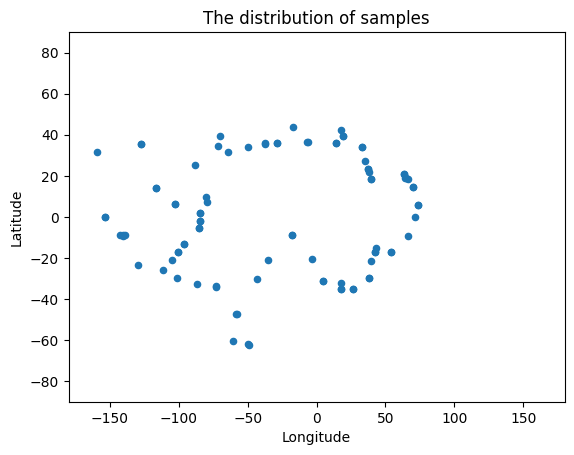

In [15]:
df_data.plot.scatter(x='Longitude', y='Latitude', title='The distribution of samples',
                     ylim=(-90,90), xlim=(-180,180))

## part 3: indicating maritime zone for each sample

In [16]:
# functions to detect whatever a point is inside a polygon or not

@numba.njit
def is_inside_postgis(polygon, point):
  """
  Determines if a point is inside a polygon using the PostGIS algorithm.

  Parameters:
  -----------
  polygon : list
      A list of (longitude, latitude) tuples representing the vertices of the polygon.
  point : tuple
      A (longitude, latitude) tuple representing the point to check.

  Returns:
  --------
  int
      If the point is inside the polygon, returns True.
      If the point is on the boundary of the polygon, returns 2.
      Otherwise, returns False.
  """
  length = len(polygon)
  intersections = 0

  dx2 = point[0] - polygon[0][0]
  dy2 = point[1] - polygon[0][1]
  jj = 1

  while jj < length:
    dx = dx2
    dy = dy2
    dx2 = point[0] - polygon[jj][0]
    dy2 = point[1] - polygon[jj][1]

    F = (dx - dx2) * dy - dx * (dy - dy2)
    if 0.0 == F and dx * dx2 <= 0 and dy * dy2 <= 0:
      return 2

    if (dy >= 0 > dy2) or (dy2 >= 0 > dy):
      if F > 0:
        intersections += 1
      elif F < 0:
        intersections -= 1

    jj += 1

  return intersections != 0

In [17]:
@numba.njit(parallel=True)
def is_inside_postgis_parallel(points, polygon):
    """
    Determines if a list of points is inside a polygon using the PostGIS algorithm,
    using parallel processing.

    Parameters:
    -----------
    points : list
        A list of (longitude, latitude) tuples representing the points to check.
    polygon : list
        A list of (longitude, latitude) tuples representing the vertices of the polygon.

    Returns:
    --------
    numpy.ndarray
        A boolean array of length `len(points)`, where each element is True 
        if the corresponding point is inside the polygon, 
        and False otherwise.
    """
    ln = len(points)
    D = np.empty(ln, dtype=numba.boolean) 
    for i in numba.prange(ln):
        D[i] = is_inside_postgis(polygon, points[i])
    return D

In [18]:
def sample_polygon_relation(zone_poly_row, row_number):
  """
  Given a GeoPandas DataFrame row with a polygon, checks 
  if any points in the global list points_list are inside
  the polygon using the function is_inside_postgis_parallel. 
  
  If there are any matches, the function appends
  the corresponding Metagenomes names and the name of the POL_TYPE of the row 
  to the global lists list_names and list_polys, respectively.

  Parameters:
  zone_poly_row (GeoPandas row): A GeoPandas DataFrame row containing a polygon.
  row_number (int): The index of the row in the DataFrame.

  Returns:
  None
  """
  global list_names, list_polys, points_list
  global df_data, df_mar_zones

  polygon = np.array(zone_poly_row.exterior.coords)
  list_of_matches = is_inside_postgis_parallel(points_list, polygon)
  sum_of_matches = sum(list_of_matches)
  if sum_of_matches > 0: # if there is at least one match
    for one_match in df_data[list_of_matches].Metagenomes:
      list_names += [one_match]
      list_polys += [df_mar_zones.POL_TYPE.iloc[row_number]]

In [19]:
# apply each polygon to a list of points and save overlapping events
list_names = []
list_polys = []

for row_number in range(len(df_mar_zones)): # each polygon
  zone_poly_row = df_mar_zones.geometry.iloc[row_number]

  try: # in case of a polygon
    sample_polygon_relation(zone_poly_row, row_number)

  except AttributeError: # in case of a multipolygon
    list_of_polygons = list(zone_poly_row.geoms) # deconstruct it to polygons
    for polygon in list_of_polygons:
      sample_polygon_relation(polygon, row_number)

In [20]:
# what kind of categories are there
set(list_polys)

{'12NM', '200NM', '24NM', 'High Seas', 'Overlapping claim'}

In [21]:
# create a new df with samples and maritime zones
df_new = pd.DataFrame([list_names, list_polys], index=['sample', 'mar_zone'])
df_new = df_new.T.groupby('sample').agg({'mar_zone': lambda x: list(x)})
df_new = df_new.reset_index()
df_new.head()

,sample,mar_zone
0,ANE_004_05M,"[200NM, 12NM]"
1,ANE_004_40M,"[200NM, 12NM]"
2,ANE_150_05M,[High Seas]
3,ANE_150_40M,[High Seas]
4,ANE_151_05M,"[200NM, High Seas]"


In [22]:
# let's have a look at controversial ones
df_new[df_new.mar_zone.apply(lambda x: len(x) > 1)]

,sample,mar_zone
0,ANE_004_05M,"[200NM, 12NM]"
1,ANE_004_40M,"[200NM, 12NM]"
4,ANE_151_05M,"[200NM, High Seas]"
5,ANE_151_80M,"[200NM, High Seas]"
11,ANW_148_05M,"[200NM, High Seas]"
39,IOS_57_05M,"[200NM, 24NM, 12NM]"
41,IOS_62_05M,"[200NM, 24NM, 12NM]"
46,MED_18_05M,"[200NM, 24NM, 12NM]"
47,MED_18_60M,"[200NM, 24NM, 12NM]"
49,MED_25_05M,"[200NM, 24NM]"


In [23]:
# if the order of samples are the same as in the original file
# let's add a column with detected maritime zones!
if all(df_data.Metagenomes == df_new['sample']):
  print('They are equal!')
  df_data['maritime_zones'] = df_new['mar_zone']

They are equal!


## part 4: visualisation

In [24]:
# to our new dataframe let's add coordinates
df_new['Longitude'] = df_data['Longitude']
df_new['Latitude'] = df_data['Latitude']

In [25]:
# count each category in total
{element: list_polys.count(element) for element in list_polys}

{'200NM': 47, 'Overlapping claim': 2, 'High Seas': 48, '24NM': 9, '12NM': 7}

In [26]:
# let's replace each sample with geographically controversial position
df_new['mar_zone'] = df_new['mar_zone'].apply(lambda x: x[0] if len(x) == 1 else 'controversial')

In [27]:
# overall, how many categories right now?
count_dict = {element: df_new['mar_zone'].str.count(element).sum() for element in df_new['mar_zone'].unique()}
count_dict

{'controversial': 15, 'High Seas': 44, '200NM': 32, 'Overlapping claim': 2}

In [28]:
# prepare a legend
label_list = [f'{group}: {count_dict[group]}' for group in count_dict.keys()]
points_legend = dict(zip(count_dict.keys(), label_list))

points_legend

{'controversial': 'controversial: 15',
 'High Seas': 'High Seas: 44',
 '200NM': '200NM: 32',
 'Overlapping claim': 'Overlapping claim: 2'}

Text(0.5, 0.95, 'Geodata of TARA_Oceans from doi: 10.1038/s41564-018-0176-9')

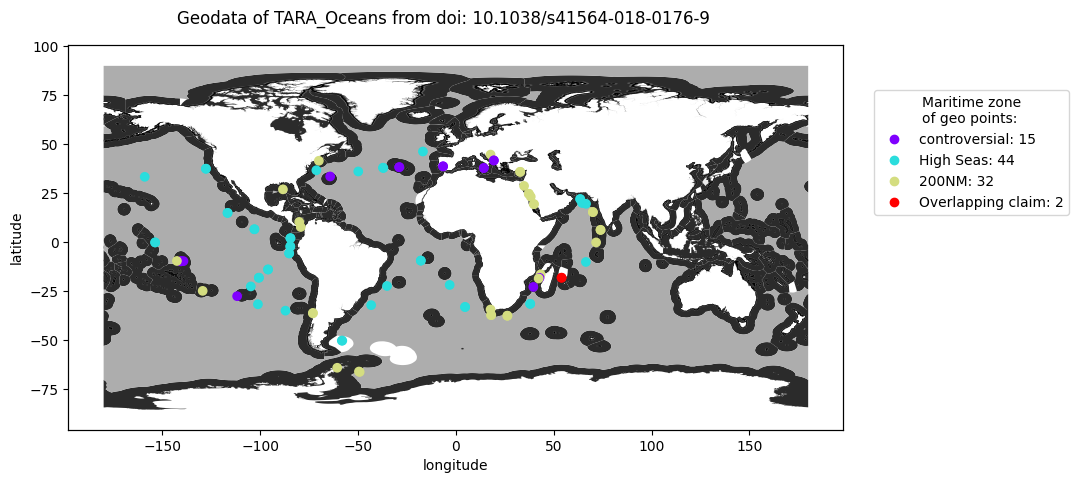

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

# draw a background with maritime zones
df_mar_zones.plot(column='POL_TYPE', cmap='Greys_r', ax=ax,
                  legend=False)
ax.set_ylim(-90, 95)
ax.set_xlabel('longitude'); ax.set_ylabel('latitude')

# add dotes as samples on top
ax2 = ax.twinx()
category_to_number = dict(zip(df_new['mar_zone'].unique(), 
                              range(len(df_new['mar_zone'].unique()))))
colors = df_new['mar_zone'].map(category_to_number)
ax2.scatter(x=df_new.Longitude, y=df_new.Latitude, c=colors, cmap='rainbow')
handles, _ = ax2.collections[0].legend_elements()
ax2.legend(handles, points_legend.values(), bbox_to_anchor=(1.3, 0.9), 
           title='Maritime zone\nof geo points:')
ax2.set_yticks([]); ax2.set_yticklabels([])
ax2.set_ylim(-90, 95)
ax2.grid()

plt.suptitle('Geodata of TARA_Oceans from doi: 10.1038/s41564-018-0176-9', y=0.95)
# plt.savefig('geo_coord_sample_coverage.png', dpi=300, bbox_inches='tight')

## part 5: saving the table with a maritime zonation column

In [30]:
df_data.head()

,Metagenomes,Number_of_sequencing_pairs,Number_of_QC_sequencing_pairs,NCBI Biosample,Location,Project,Depth_(m),Depth_Id,Size_fractionnation_(um),Year,...,Chlorophyll Sensor s,Mean_Temperature,Mean_Salinity,Mean_Oxygen,Mean_Nitrates,NO2,PO4,NO2NO3,SI,maritime_zones
0,ANE_004_05M,202168446,184535177,SAMEA2619376,Atlantic_Ocean_(North_East),TARA_Oceans,10.000000,SRF,0.22-1.6,2009,...,0.078000,20.5,36.6,NaN,NaN,NaN,NaN,NaN,NaN,"[200NM, 12NM]"
1,ANE_004_40M,238146548,211851937,SAMEA2619399,Atlantic_Ocean_(North_East),TARA_Oceans,38.689029,DCM,0.22-1.6,2009,...,0.090621,16.2,36.6,NaN,NaN,NaN,NaN,NaN,NaN,"[200NM, 12NM]"
2,ANE_150_05M,193884779,174174635,SAMEA2623808,Atlantic_Ocean_(North_East),TARA_Oceans,5.530167,SRF,0.22-3,2012,...,0.048898,17.6,36.3,228.4,-0.3,0.04,0.01,0.17,0.84,[High Seas]
3,ANE_150_40M,182027367,166816431,SAMEA2623826,Atlantic_Ocean_(North_East),TARA_Oceans,39.779235,DCM,0.22-3,2012,...,0.132494,17.7,36.2,230.1,1.2,0.04,0.00,0.17,0.84,[High Seas]
4,ANE_151_05M,198143365,177719925,SAMEA2623850,Atlantic_Ocean_(North_East),TARA_Oceans,5.402083,SRF,0.22-3,2012,...,0.041900,17.3,36.2,232.1,0.3,0.02,0.01,0.02,0.65,"[200NM, High Seas]"


In [32]:
df_data.to_csv('samples_with_maritime_zones.csv', index=False)